In [199]:
import pandas
import numpy as np
import csv
%matplotlib inline
import matplotlib.pyplot as plot
import sklearn.linear_model
from sklearn.impute import KNNImputer
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler

In [134]:
#import and read files
df_cleveland = pandas.read_csv("processed.cleveland_H.data", sep=",",encoding='unicode_escape', header=None)
df_hungarian = pandas.read_csv("processed.hungarian_H.data", sep=",",encoding='unicode_escape', header=None)
df_switzerland = pandas.read_csv("processed.switzerland_H.data", sep=",",encoding='unicode_escape', header=None)
df_va = pandas.read_csv("processed.va_H.data", sep=",",encoding='unicode_escape', header=None)

In [358]:
#create dataframe
df = [df_cleveland, df_hungarian, df_switzerland, df_va]
full_df = pandas.concat(df)
full_df.columns=['age','sex', 'chest pain type', 'resting bp(mm/Hg)', 
                 'serum cholesterol(mg/dl)', 'fasting bs', 'resting ecg',
                'max hr', 'ex induced angina', 'ST depression', 'slope',
                'nmv', 'thal', 'diagnosed prediction']

#we need the data as x and y where x is the data set and y is the target value
#For y, we take the target value or diagnosed predictions so that any value greater than
#0, is assigned 1. This means if there was no presence of heart disease, then
#0 is assigned, and any presence (1-4) is assigned 1. This will help scale the 
#our predictions as this is a classification approach.

#clean data
#convert all data if numerical to float(except diagnoses prediction)
#if data isn't numerical, make it NaN
full_df = full_df.apply(pandas.to_numeric, errors='coerce')

x = full_df.drop('diagnosed prediction', axis=1)
y = full_df.drop(['age','sex', 'chest pain type', 'resting bp(mm/Hg)', 
                 'serum cholesterol(mg/dl)', 'fasting bs', 'resting ecg',
                'max hr', 'ex induced angina', 'ST depression', 'slope',
                'nmv', 'thal'], axis=1)

In [404]:
#We plan on having 6 different cases. To avoid a data leak, the plan is to
#split the data into 70/15/15 as per literaure. Or 70% for training, 15% for validation, 
#15% for testing. From here, we will then impute and scale each set of data.
#In total there will be 6x3=18 data sets. 6 will be trained, 6 will be used for
#validation, and 6 will be used for testing.

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=40)


,age,sex,chest pain type,resting bp(mm/Hg),serum cholesterol(mg/dl),fasting bs,resting ecg,max hr,ex induced angina,ST depression,slope,nmv,thal
161,67.0,1.0,4.0,NaN,369.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
242,54.0,1.0,4.0,130.0,242.0,0.0,0.0,91.0,1.0,1.0,2.0,NaN,NaN
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,NaN,3.0
73,45.0,0.0,4.0,132.0,297.0,0.0,0.0,144.0,0.0,0.0,NaN,NaN,NaN
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,53.0,1.0,4.0,124.0,260.0,0.0,1.0,112.0,1.0,3.0,2.0,NaN,NaN
165,57.0,1.0,4.0,132.0,207.0,0.0,0.0,168.0,1.0,0.0,1.0,0.0,7.0
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0
219,59.0,1.0,4.0,138.0,271.0,0.0,2.0,182.0,0.0,0.0,1.0,0.0,3.0


In [405]:
#An issue with the data is that much of it, depending on its source
#contains missing values denoted as "?". We took those values and
#replaced them with "NaN". Now, we're going to look at multiple
#cases where we attempt to find ways to work around these missing values

#First, let's create a scaling function

#Here we created a function named scaled which takes in x, a dataframe.
#It will then scaled all the data between 0-1 as this works best for neural networks.
#We will assign this function to every dataframe we intend on using (training/testing).
def scale(x):
    minimax_scaler = preprocessing.MinMaxScaler()
    scaled = pandas.DataFrame(minimax_scaler.fit_transform(x.values), columns=x.columns, 
                              index=x.index)
    return scaled

#Case 1: Now that we have separated the data, we are going to impute it.
#Our first imputition technique will setting all NaN values to 0.
#We are also going to scale the data between 0-1. This range works best 
#for neural networks
df1_train_data = x_train.fillna(0)
df1_test_data = x_test.fillna(0)
df1_val_data = x_val.fillna(0)

#Now, let's scale each set of data.
df1_train_scaled= scale(df1_train_data)
df1_test_scaled= scale(df1_test_data)
df1_val_scaled= scale(df1_val_data)

#Now that we have split, imputed, and scaled the data. Let's do the same for the rest of
#our cases


In [406]:
#case 2: Our second imputation technique is to delete all instances 
#with NaN values, this cuts our number of instances in third
df2_train_data = x_train.dropna()
df2_test_data = x_test.dropna()
df2_val_data = x_val.dropna()

#scale
df2_train_scaled= scale(df2_train_data)
df2_test_scaled= scale(df2_test_data)
df2_val_scaled= scale(df2_val_data)


In [407]:
#case 3: Here we are going to delete all features with NaN value
#cuts our number of features roughly in fourth
df3_train_data = x_train.dropna(axis=1)
df3_test_data = x_test.dropna(axis=1)
df3_val_data = x_val.dropna(axis=1)


#scale
df3_train_scaled= scale(df3_train_data)
df3_test_scaled= scale(df3_test_data)
df3_val_scaled= scale(df3_val_data)


In [408]:
#case 4: Here we are using a Predictive Value Imputation (PVI) which will 
#take the individual mean of columns containing missing values and replace
#the NaN, or missing values with the mean
df4_train_data= x_train.fillna(x_train.mean())
df4_test_data= x_test.fillna(x_test.mean())
df4_val_data= x_val.fillna(x_val.mean())


#scale
df4_train_scaled= scale(df4_train_data)
df4_test_scaled= scale(df4_test_data)
df4_val_scaled= scale(df4_val_data)


In [409]:
#case 5: Here we are using a Predictive Value Imputation (PVI) which will 
#take the individual mean of columns containing missing values and replace
#the NaN, or missing values with the median
df5_train_data = x_train.fillna(x_train.median())
df5_test_data = x_test.fillna(x_test.median())
df5_val_data = x_val.fillna(x_val.median())

#scale
df5_train_scaled= scale(df5_train_data)
df5_test_scaled= scale(df5_test_data)
df5_val_scaled= scale(df5_val_data)


In [413]:
#case 6: Here we are going to use k-NearestNeighbor(kNN) imputation, which is 
#another PVI to predict the missing values of each column. 
#We are going to use kNN on the data set with a k value set to 4.

#first let's create a kNN imputation function
def kNNimpute(x):
    kNNimputer = KNNImputer(n_neighbors=4)
    imputed = pandas.DataFrame(kNNimputer.fit_transform(x), columns=x.columns, index=x.index)
    
    return imputed

df6_train_data = kNNimpute(x_train)
df6_test_data = kNNimpute(x_test)
df6_val_data = kNNimpute(x_val)

#scale
df6_train_scaled= scale(df6_train_data)
df6_test_scaled= scale(df6_test_data)
df6_val_scaled= scale(df6_val_data)


,age,sex,chest pain type,resting bp(mm/Hg),serum cholesterol(mg/dl),fasting bs,resting ecg,max hr,ex induced angina,ST depression,slope,nmv,thal
161,0.791667,1.0,1.000000,0.6875,0.611940,0.0,0.0,0.592308,0.0,0.318182,0.25,0.083333,0.5000
242,0.520833,1.0,1.000000,0.6500,0.401327,0.0,0.0,0.238462,1.0,0.409091,0.50,0.166667,0.6875
166,0.479167,1.0,0.666667,0.6900,0.369818,0.0,0.0,0.838462,0.0,0.295455,0.00,0.166667,0.0000
73,0.333333,0.0,1.000000,0.6600,0.492537,0.0,0.0,0.646154,0.0,0.295455,0.25,0.333333,0.7500
266,0.479167,1.0,1.000000,0.6400,0.338308,1.0,0.0,0.738462,1.0,0.409091,0.50,0.000000,0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.500000,1.0,1.000000,0.6200,0.431177,0.0,0.5,0.400000,1.0,0.636364,0.50,0.416667,1.0000
165,0.583333,1.0,1.000000,0.6600,0.343284,0.0,0.0,0.830769,1.0,0.295455,0.00,0.000000,1.0000
7,0.583333,0.0,1.000000,0.6000,0.587065,0.0,0.0,0.792308,1.0,0.363636,0.00,0.000000,0.0000
219,0.625000,1.0,1.000000,0.6900,0.449420,0.0,1.0,0.938462,0.0,0.295455,0.00,0.000000,0.0000


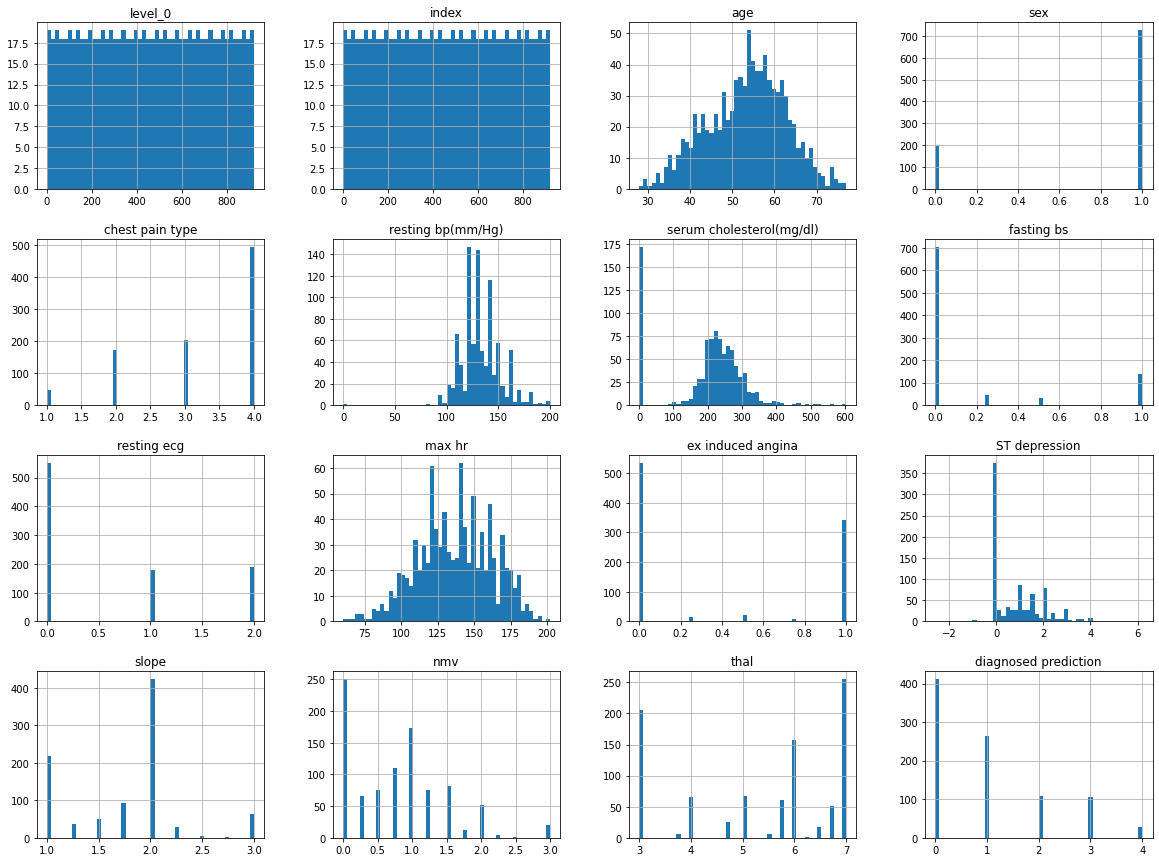

In [411]:
%matplotlib inline
df_8.hist(bins=50, figsize=(20,15))
plot.show()

,age,sex,chest pain type,resting bp(mm/Hg),serum cholesterol(mg/dl),fasting bs,resting ecg,max hr,ex induced angina,ST depression,slope,nmv,thal,diagnosed prediction
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,54.0,0.0,4.0,127.0,333.0,1.0,1.0,154.0,0.0,0.0,NaN,NaN,NaN,1
196,62.0,1.0,1.0,NaN,139.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0
197,55.0,1.0,4.0,122.0,223.0,1.0,1.0,100.0,0.0,0.0,NaN,NaN,6.0,2
198,58.0,1.0,4.0,NaN,385.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0
